## AB Tests Сафроненков Р. С.

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [1]:
# !pip install causalml

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


### Task 1

In [3]:
task1 = pd.read_csv('./dataset_part1_students.csv', sep='\t')

In [4]:
task1.head()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656


In [5]:
task1.corr()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
y,1.000000,0.065850,0.008930,-0.004498,-0.011011,0.088885,0.038744,0.017261,0.007687,-0.010386,-0.009748,0.006415
W,0.065850,1.000000,0.348577,0.350024,-0.013377,0.005773,0.000631,0.004444,0.002942,-0.001003,0.002110,-0.001818
X_1,0.008930,0.348577,1.000000,-0.000354,0.001252,0.009507,-0.004616,0.011968,0.006329,0.002976,0.002121,0.004894
X_2,-0.004498,0.350024,-0.000354,1.000000,-0.003164,-0.006788,0.008451,0.002302,0.006326,-0.001646,-0.008786,0.002035
X_3,-0.011011,-0.013377,0.001252,-0.003164,1.000000,-0.003472,-0.007262,-0.003872,0.004052,-0.006677,-0.000599,-0.009377
X_4,0.088885,0.005773,0.009507,-0.006788,-0.003472,1.000000,-0.010954,-0.001131,0.001923,-0.002946,0.005611,0.021488
X_5,0.038744,0.000631,-0.004616,0.008451,-0.007262,-0.010954,1.000000,-0.008475,-0.007144,-0.003614,0.008272,-0.003380
X_6,0.017261,0.004444,0.011968,0.002302,-0.003872,-0.001131,-0.008475,1.000000,0.000642,0.001326,0.006686,0.005137
X_7,0.007687,0.002942,0.006329,0.006326,0.004052,0.001923,-0.007144,0.000642,1.000000,-0.006870,0.006863,-0.003441
X_8,-0.010386,-0.001003,0.002976,-0.001646,-0.006677,-0.002946,-0.003614,0.001326,-0.006870,1.000000,0.000887,-0.004628


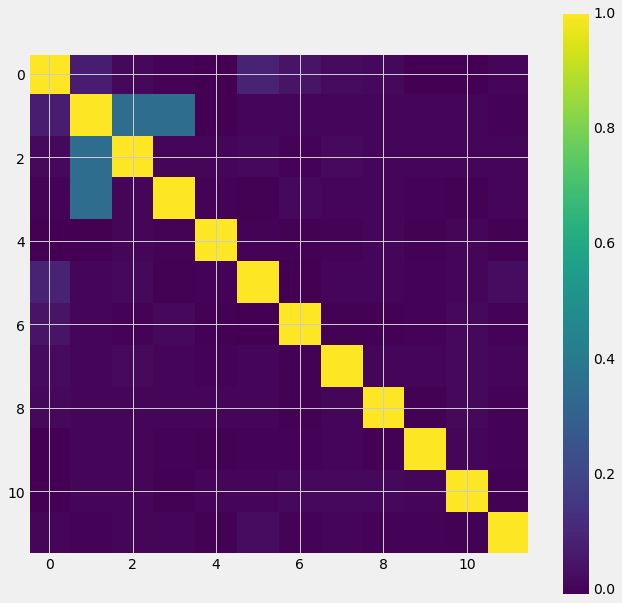

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(task1.corr())
plt.colorbar()
plt.show()

По двум X, а именно по X_1 и X_2 есть небольшое расхождение в treatment и control группах, также наблюдается небольшая зависимость W от X_1 и X_2 (коэффициент корреляции порядка 0.35), но не сильная. Во всех же остальных все достаточно равномерно. Тем не менее предположим unconfoundedness

Text(0.5, 1.0, 'W=1, X_2')

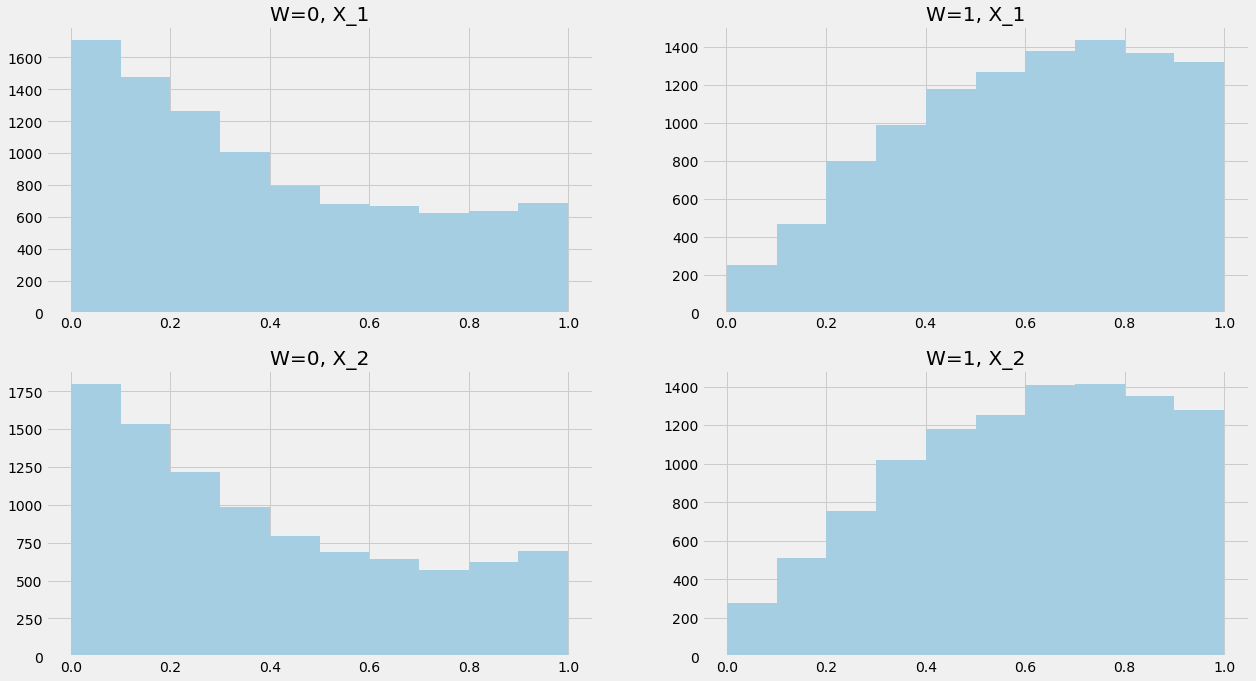

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(19.20, 10.80))
task1[task1['W'] == 0].X_1.hist(ax=ax[0][0])
ax[0][0].set_title('W=0, X_1')
task1[task1['W'] == 1].X_1.hist(ax=ax[0][1])
ax[0][1].set_title('W=1, X_1')
task1[task1['W'] == 0].X_2.hist(ax=ax[1][0])
ax[1][0].set_title('W=0, X_2')
task1[task1['W'] == 1].X_2.hist(ax=ax[1][1])
ax[1][1].set_title('W=1, X_2')

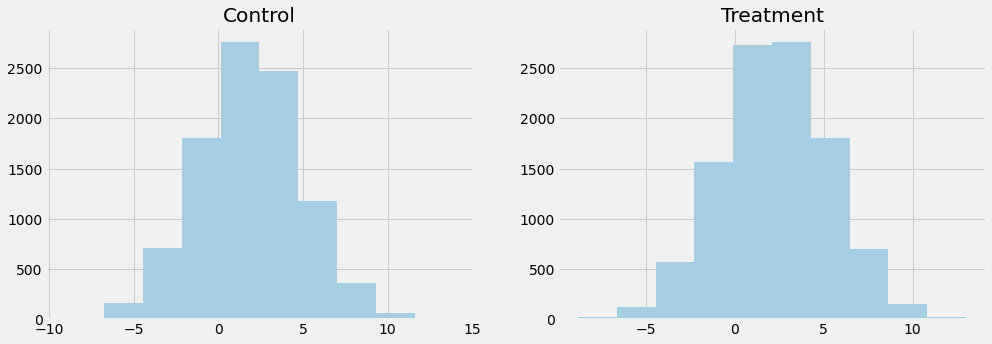

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Control')
ax[1].set_title('Treatment')
task1[task1['W'] == 0].y.hist(ax=ax[0])
task1[task1['W'] == 1].y.hist(ax=ax[1])

Предположим независимость 

In [9]:
st.ttest_ind(task1[task1['W'] == 0].y.values, task1[task1['W'] == 1].y.values)

Ttest_indResult(statistic=-9.332400850259313, pvalue=1.1400916649505329e-20)

Значение p-value в t-тесте получилось куда меньше 0.05, а значит мы можем отвергнуть нулевую гипотезу о равенстве средних и принять альтернативную.

Применив предположение о независимости W от y(0) и y(1), посчитаем наивный ATE

In [10]:
y_mean_control = task1[task1['W'] == 0].y.mean()
y_mean_treatment = task1[task1['W'] == 1].y.mean()
ATE = y_mean_treatment - y_mean_control
ATE

0.4001031055444413

Посчитаем ATE с помощью линейной регрессии, построим матрицу признаков так, что нас будет интересовать коэффициент с индексом 1, которому будет соответствовать W.

In [11]:
X = task1.drop('y', axis=1).values
y = task1.y.values
X = np.hstack((np.ones((20000, 1)), X))

In [12]:
def least_squares_weights(x, y):
    w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    return w

W = least_squares_weights(X, y)

In [13]:
W

array([ 1.41984951,  0.51338549, -0.2254694 , -0.35712379, -0.09795053,
        0.93446704,  0.42135781,  0.18572004,  0.08389393, -0.10409036,
       -0.11725869,  0.04936036])

In [14]:
ATE_reg = W[1]
ATE_reg

0.5133854882565599

Значения средних treatment и control не равны, наивным способом полученный ATE приблизительно равнен 0.4. в то время как регрессионным способом он равен приблизительно 0.51. В целом можно утверждать, что полученные разными способами ATE отличаются не сильно.

### Task 2

In [15]:
task2 = pd.read_csv('./dataset_part2_students.csv', sep='\t')

In [16]:
task2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209


In [17]:
task2.corr()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
y_1,1.000000,0.026080,0.103788,0.007865,0.003906,-0.019998,0.137762,0.090937,0.010558,0.028195,0.014421,-0.006330,-0.001192
y_0,0.026080,1.000000,-0.026940,-0.045420,-0.032895,-0.056675,0.120457,0.067586,-0.001475,0.017152,-0.005587,0.001407,0.009914
W,0.103788,-0.026940,1.000000,0.355977,0.341470,0.011389,-0.008195,0.006970,-0.007141,-0.005273,-0.009837,0.004040,-0.001986
X_1,0.007865,-0.045420,0.355977,1.000000,0.006024,0.006819,-0.009342,-0.005765,0.008396,-0.008029,-0.009670,-0.005707,0.000291
X_2,0.003906,-0.032895,0.341470,0.006024,1.000000,-0.016451,-0.008442,0.005985,-0.003123,0.013119,0.001638,0.019367,-0.004514
X_3,-0.019998,-0.056675,0.011389,0.006819,-0.016451,1.000000,-0.009480,-0.004786,-0.009218,-0.014352,-0.011449,0.008604,-0.007816
X_4,0.137762,0.120457,-0.008195,-0.009342,-0.008442,-0.009480,1.000000,0.013385,0.012685,-0.001230,-0.006916,0.004548,0.015459
X_5,0.090937,0.067586,0.006970,-0.005765,0.005985,-0.004786,0.013385,1.000000,-0.012967,0.008335,-0.003052,-0.009575,-0.004140
X_6,0.010558,-0.001475,-0.007141,0.008396,-0.003123,-0.009218,0.012685,-0.012967,1.000000,-0.000864,0.003833,0.004813,0.016465
X_7,0.028195,0.017152,-0.005273,-0.008029,0.013119,-0.014352,-0.001230,0.008335,-0.000864,1.000000,0.020473,-0.004533,-0.004545


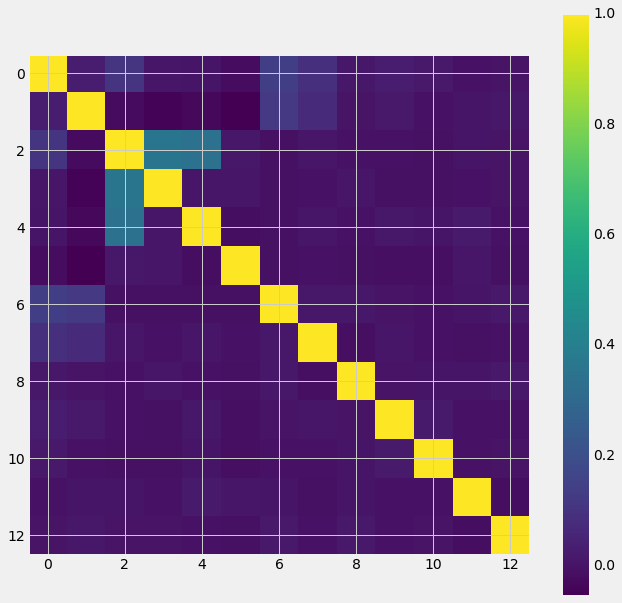

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(task2.corr())
plt.colorbar()
plt.show()

Для распределения X_1 и X_2 для treatment и control групп получаем аналогичную первому заданию ситуацию

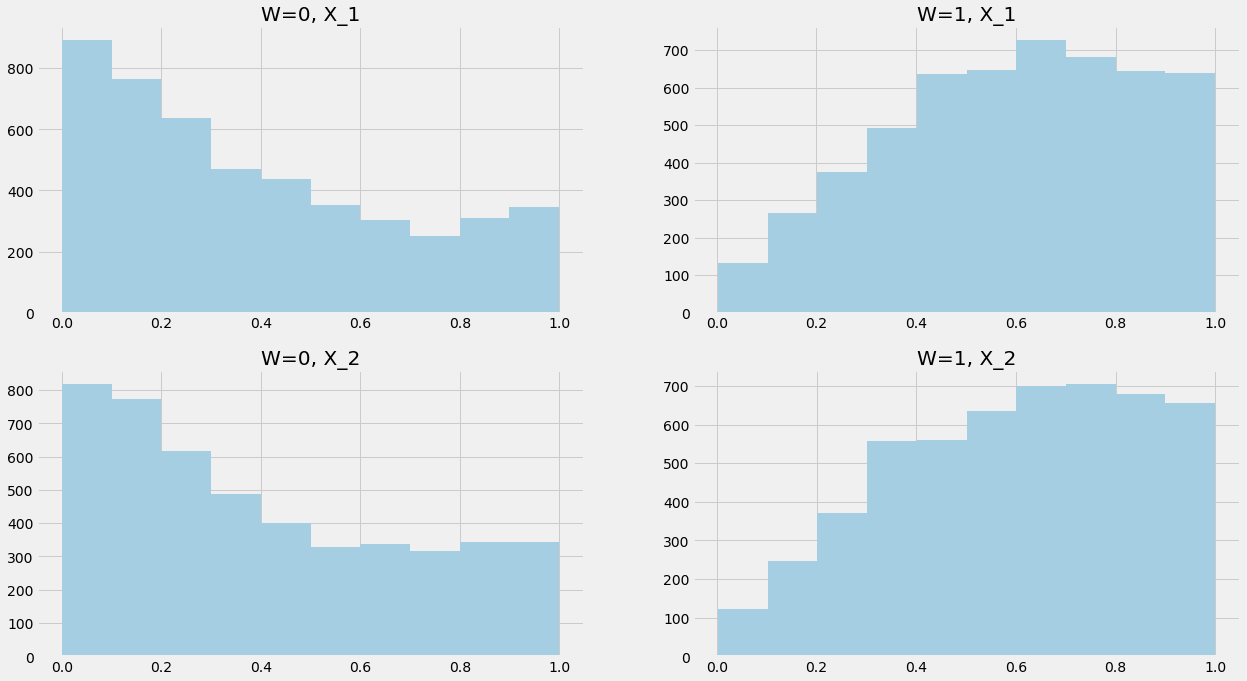

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(19.20, 10.80))
task2[task2['W'] == 0].X_1.hist(ax=ax[0][0])
ax[0][0].set_title('W=0, X_1')
task2[task2['W'] == 1].X_1.hist(ax=ax[0][1])
ax[0][1].set_title('W=1, X_1')
task2[task2['W'] == 0].X_2.hist(ax=ax[1][0])
ax[1][0].set_title('W=0, X_2')
task2[task2['W'] == 1].X_2.hist(ax=ax[1][1])
ax[1][1].set_title('W=1, X_2')
plt.show()

Опять же, предполагаем независимость и делаем t-test для сравнения средних

In [20]:
st.ttest_ind(task2[task2['W'] == 0].y_0.values, task2[task2['W'] == 1].y_0.values)

Ttest_indResult(statistic=2.6947405425339337, pvalue=0.007056118548053932)

In [21]:
st.ttest_ind(task2[task2['W'] == 0].y_1.values, task2[task2['W'] == 1].y_1.values)

Ttest_indResult(statistic=-10.434076818229196, pvalue=2.3383131389683154e-25)

В обоих случаях (до и после эксперимента), получаем значимые различия в средних, значит у нас уже перед проведением эксперимента были значимые различия в целевой переменной

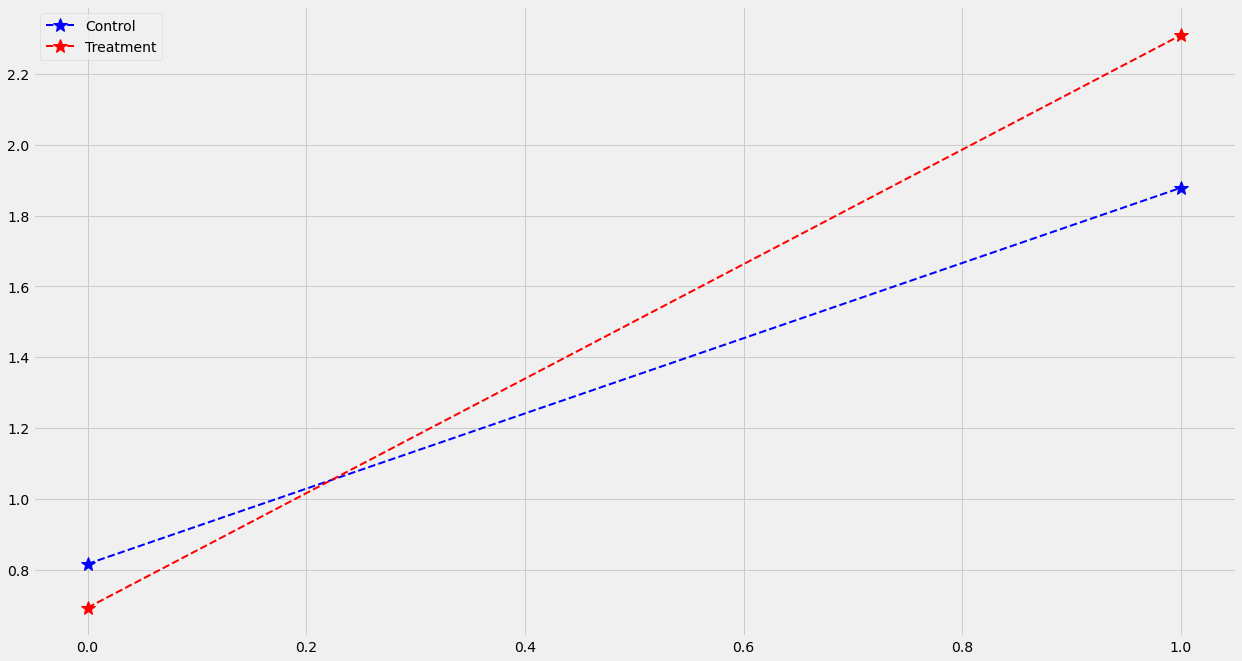

In [22]:
plt.figure(figsize=(19.20, 10.80))
plt.plot([task2[task2['W'] == 0].y_0.mean(), task2[task2['W'] == 0].y_1.mean()], 'b--*', lw=2, markersize=15, label='Control')
plt.plot([task2[task2['W'] == 1].y_0.mean(), task2[task2['W'] == 1].y_1.mean()], 'r--*', lw=2, markersize=15, label='Treatment')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Также моем оценить наивный ATE

In [23]:
y_mean_control = task2[task2['W'] == 0].y_1.mean()
y_mean_treatment = task2[task2['W'] == 1].y_1.mean()
ATE = y_mean_treatment - y_mean_control
ATE

0.4312515969250956

И посчитать ATE регрессией, аналогично первому пункту

In [24]:
X = task2.drop(['y_1', 'y_0'], axis=1).values
y = task2.y_1.values
X = np.hstack((np.ones((10000, 1)), X))

In [25]:
W = least_squares_weights(X, y)

In [26]:
W

array([ 1.19668021,  0.54819353, -0.26450508, -0.29520182, -0.13939715,
        0.98123444,  0.630464  ,  0.07867569,  0.20037582,  0.11304867,
       -0.04206806, -0.02257477])

In [27]:
ATE_reg = W[1]
ATE_reg

0.5481935343179251

Теперь перейдем к оценкам ATE с использованием данных до эксперимента

In [28]:
task2['vid'] = task2.index.tolist()

In [29]:
task2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,vid
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310,0
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161,1
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056,2
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770,3
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209,4


Создадим дополнительный DataFrame, в котором вытянем два значения y в один столбец, и сделаем необходимые дополнительные признаки для difference in differences

In [30]:
new_task2 = pd.concat((task2['y_1'], task2['y_0'])).to_frame().reset_index().rename({0:'y', 'index':'vid'}, axis=1)
new_task2 = new_task2.merge(task2, on='vid').drop(['y_1', 'y_0'], axis=1)

In [31]:
new_task2.head()

,vid,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,0,5.887156,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,0,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
2,1,2.232601,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
3,1,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
4,2,0.144419,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056


Таким наивным способом (но рабочим, исходя из того как я делал merge), создадим переменную-индикатор для времени, назовем его time, создадим фиктивную переменную для учета intercept, а также создадим переменную-произведение времени и индикатора времени и W

In [32]:
lst = []
for i in range(10000):
    lst.extend([1, 0])

In [33]:
new_task2['time'] = lst
new_task2['intercept'] = 1
new_task2['t_w'] = new_task2['time'] * new_task2['W']

In [34]:
new_task2.head()

,vid,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,time,intercept,t_w
0,0,5.887156,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310,1,1,1.0
1,0,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310,0,1,0.0
2,1,2.232601,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161,1,1,0.0
3,1,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161,0,1,0.0
4,2,0.144419,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056,1,1,1.0


Теперь создадим переменные для регрессии difference in differences (intercept, индикатор момента времени, индикатор принадлежности к целевой группе и произведение двух последних)

In [35]:
X = new_task2[['intercept', 'time', 'W', 't_w']].values
y = new_task2['y'].values

Построим регрессионную модель, и получим ATE, он будет коэффициентом при последней переменной

In [36]:
W = least_squares_weights(X, y)
W

array([ 0.81618702,  1.06235456, -0.12365317,  0.55490477])

In [37]:
ATE_diff_in_diff = W[3]
ATE_diff_in_diff

0.5549047702971186

Получили ATE с помощью difference in differences, получился очень схожим с оценкой обычной регрессией. Теперь сделаем оценку ANCOVA

In [38]:
task2['intercept'] = 1

In [39]:
X = task2[['intercept', 'y_0', 'W']]
y = task2.y_1.values

In [40]:
W = least_squares_weights(X, y)

In [41]:
ATE_ancova = W[2]
ATE_ancova

0.43448638144566576

Учитывая y_0, получаем оценку, близкую к наивной оценке, попробуем с учетом X_1 и X_2, которые, как показано выше лучше всего коррелируют с y_1

In [42]:
X = task2[['intercept', 'X_1', 'X_2', 'W']]
y = task2.y_1.values

In [43]:
W = least_squares_weights(X, y)

In [44]:
ATE_ancova = W[3]
ATE_ancova

0.5463124912303482

Получаем оценку, близкую к difference in differences и регрессии.

В результате можно сказать, что наиболее применимые в данном случае методы оценки это difference in differences и ANCOVA, оба показали значение около 0.55

### Task 3

In [45]:
task3 = pd.read_csv('./dataset_part3_students.csv', sep='\t')

In [46]:
task3.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


In [47]:
task3['W'] = task3['treatment'].map({'treatment':1, 'control':0})

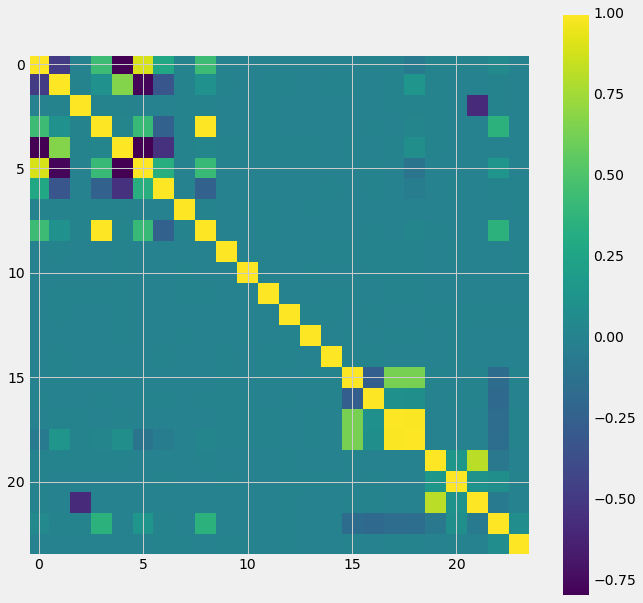

In [48]:
plt.figure(figsize=(10, 10))
plt.imshow(task3.corr())
plt.colorbar()
plt.show()

In [49]:
task3

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,W
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,control,-1.309691,2.925832,-0.584101,-1.232931,2.601140,-4.943288,0.416758,-0.083626,-1.232931,-0.156886,-0.009209,1.938339,0.374788,1.041399,0.975982,0.636279,1.073711,-0.406603,0.027760,-0.478887,1.265746,0.059865,0,0
199996,control,-1.131361,1.562317,1.265630,-1.361879,1.169695,-3.247293,1.253718,-1.968727,-1.361879,1.487681,1.341897,-0.042151,0.695421,-0.485884,0.674360,0.892121,0.893261,0.182528,0.338611,1.006028,-1.943045,-0.145377,0,0
199997,control,0.442433,2.202153,-0.380019,-0.474935,0.766306,-1.722354,0.751083,0.595800,-0.474935,-1.133214,0.474008,-2.370446,-0.496472,1.098074,0.299918,0.718669,1.031289,0.398560,0.591750,1.620529,-1.081292,0.995816,0,0
199998,treatment,-0.084879,0.423688,0.389931,-1.996510,-0.123098,-1.103408,2.207197,0.402468,-1.996510,-0.251343,-1.136188,0.842605,-0.296565,-0.511203,-0.150816,-0.256026,2.231563,0.848577,0.739235,1.656343,0.436962,0.622010,0,1


Посчитаем ATE, используя библиотеку causalml. Различными способами.

In [51]:
X = task3.drop(['treatment', 'conversion', 'W'], axis=1).values
treatment = task3['W'].values
y = task3['conversion']

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.06 (0.06, 0.06)
[16:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (XGBoost): 0.06 (0.06, 0.06)
Average Treatment Effect (Neural Network (MLP)): 0.04 (0.04, 0.04)


Получим CATE с использованием X learner и XGBRegressor

In [52]:
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

[16:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
task3['cate_x'] = cate_x_no_p

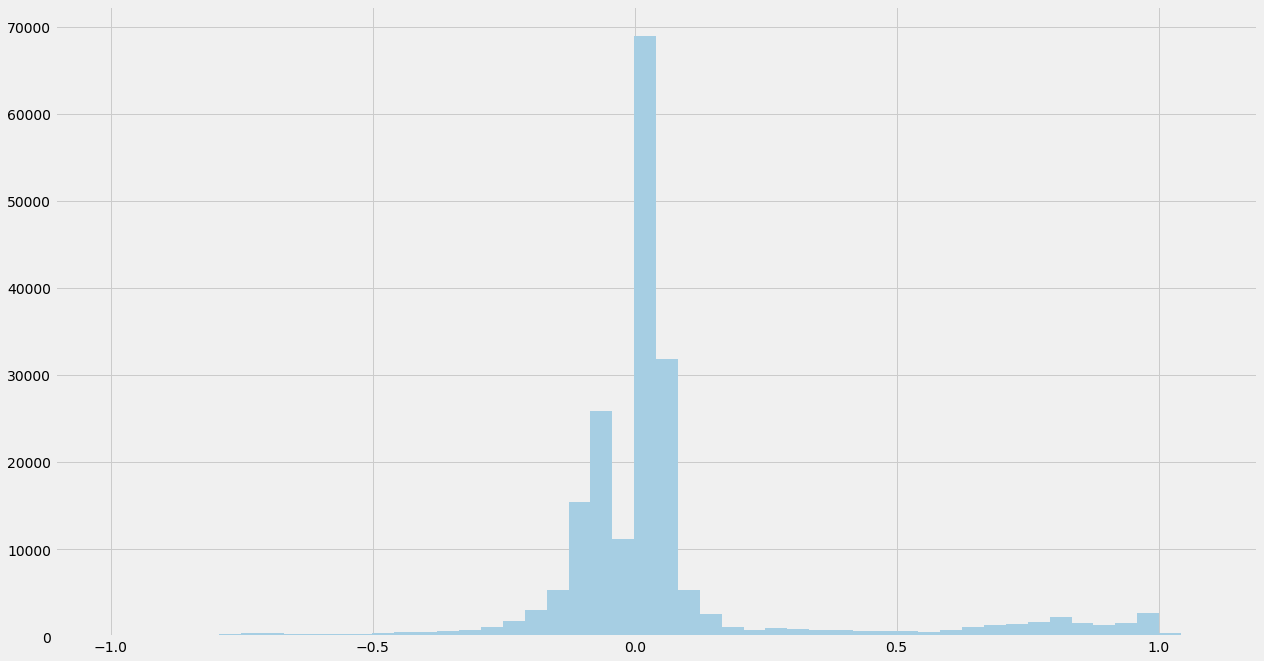

In [54]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes()
task3['cate_x'].hist(ax=ax, bins=50)
plt.show()

In [55]:
task3

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,W,cate_x
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0,0.023380
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,0,0.023806
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0,0.022708
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,1,0.893564
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0,0.023378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,control,-1.309691,2.925832,-0.584101,-1.232931,2.601140,-4.943288,0.416758,-0.083626,-1.232931,-0.156886,-0.009209,1.938339,0.374788,1.041399,0.975982,0.636279,1.073711,-0.406603,0.027760,-0.478887,1.265746,0.059865,0,0,0.043830
199996,control,-1.131361,1.562317,1.265630,-1.361879,1.169695,-3.247293,1.253718,-1.968727,-1.361879,1.487681,1.341897,-0.042151,0.695421,-0.485884,0.674360,0.892121,0.893261,0.182528,0.338611,1.006028,-1.943045,-0.145377,0,0,-0.089170
199997,control,0.442433,2.202153,-0.380019,-0.474935,0.766306,-1.722354,0.751083,0.595800,-0.474935,-1.133214,0.474008,-2.370446,-0.496472,1.098074,0.299918,0.718669,1.031289,0.398560,0.591750,1.620529,-1.081292,0.995816,0,0,-0.067830
199998,treatment,-0.084879,0.423688,0.389931,-1.996510,-0.123098,-1.103408,2.207197,0.402468,-1.996510,-0.251343,-1.136188,0.842605,-0.296565,-0.511203,-0.150816,-0.256026,2.231563,0.848577,0.739235,1.656343,0.436962,0.622010,0,1,-0.048530


Получив CATE, сделаем грубые рекомендации. Пусть мы теперь будем ставить в treatment людей, у которых CATE больше 0.5.

In [58]:
task3['recommendation'] = (task3['cate_x'] > 0.5).astype(int)

In [59]:
task3

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion,W,cate_x,recommendation
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,-0.807218,1.318646,-0.065262,-0.956947,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0,0,0.023380,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,-0.460971,-1.396720,0.600044,1.000000,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0,0,0.023806,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,-1.430502,0.469694,1.251940,0.943003,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0,0,0.022708,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,0.408691,-0.422736,-1.593407,0.247038,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1,1,0.893564,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,-0.243256,0.598662,0.750706,0.554053,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0,0,0.023378,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,control,-1.309691,2.925832,-0.584101,-1.232931,2.601140,-4.943288,0.416758,-0.083626,-1.232931,-0.156886,-0.009209,1.938339,0.374788,1.041399,0.975982,0.636279,1.073711,-0.406603,0.027760,-0.478887,1.265746,0.059865,0,0,0.043830,0
199996,control,-1.131361,1.562317,1.265630,-1.361879,1.169695,-3.247293,1.253718,-1.968727,-1.361879,1.487681,1.341897,-0.042151,0.695421,-0.485884,0.674360,0.892121,0.893261,0.182528,0.338611,1.006028,-1.943045,-0.145377,0,0,-0.089170,0
199997,control,0.442433,2.202153,-0.380019,-0.474935,0.766306,-1.722354,0.751083,0.595800,-0.474935,-1.133214,0.474008,-2.370446,-0.496472,1.098074,0.299918,0.718669,1.031289,0.398560,0.591750,1.620529,-1.081292,0.995816,0,0,-0.067830,0
199998,treatment,-0.084879,0.423688,0.389931,-1.996510,-0.123098,-1.103408,2.207197,0.402468,-1.996510,-0.251343,-1.136188,0.842605,-0.296565,-0.511203,-0.150816,-0.256026,2.231563,0.848577,0.739235,1.656343,0.436962,0.622010,0,1,-0.048530,0


In [62]:
new_cate = learner_x_no_p.fit_predict(X, task3['recommendation'].values, y)

[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


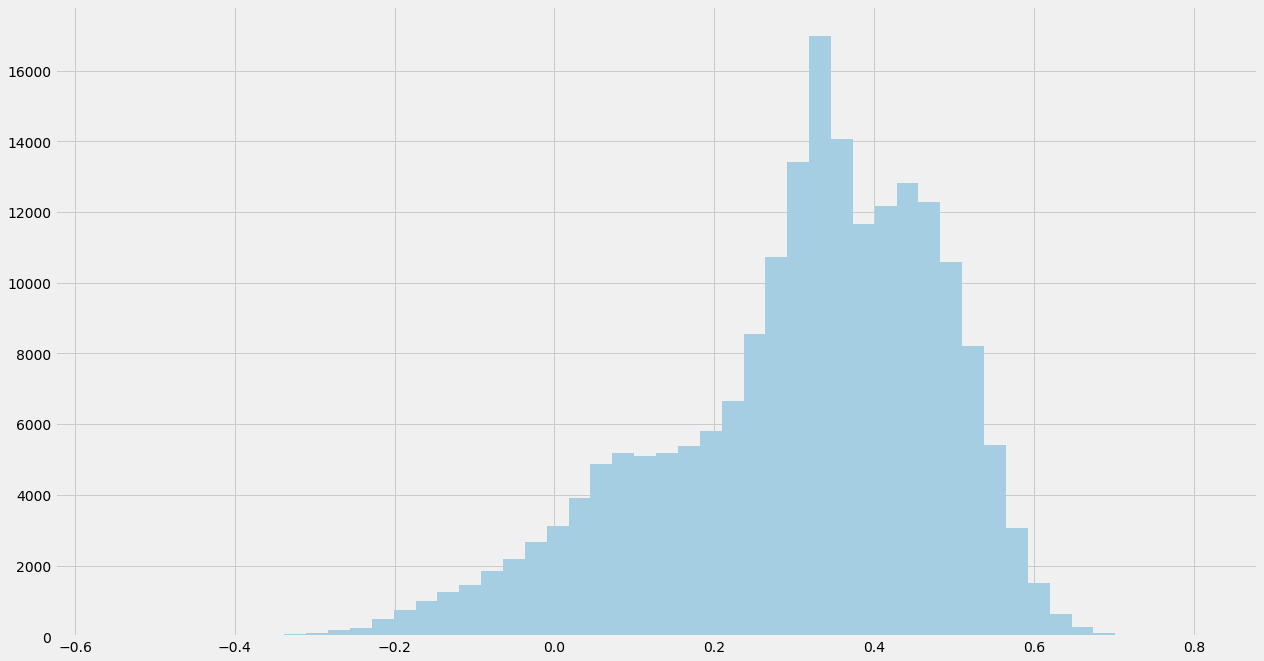

In [63]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes()
ax.hist(new_cate, bins=50)
plt.show()